In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from utils import validate_segmentation, plot_prediction, dice_score
from torchvision.transforms import functional as TF
from torch.autograd import Variable
from tqdm import tqdm
import random
import cv2
import torchio as tio
from pathlib import Path
import seaborn as sns
import copy

#check if colab is being used
if os.path.exists('/content'):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    torch.cuda.empty_cache()

path_to_mask = 'data/patients/labels/'
path_to_imgs = 'data/patients/imgs/'
path_to_controls = 'data/controls/imgs/' #healthy individuals (no tumors)
dataset_path = 'data.zip'
dataset_dir_name = 'data'
dataset_dir = Path(dataset_dir_name)

if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

print(dataset_dir)

data
├── controls
│   └── imgs
└── patients
    ├── imgs
    └── labels

5 directories
data


## Reading image data

In [5]:
images_dir = dataset_dir / 'patients/imgs'
print(images_dir)
labels_dir = dataset_dir / 'patients/labels'
controls_dir = dataset_dir / 'controls/imgs'
image_paths = sorted(images_dir.glob('*.png'))
label_paths = sorted(labels_dir.glob('*.png'))
control_paths = sorted(controls_dir.glob('*.png'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        img=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)

print('Dataset size:', len(dataset), 'subjects')

data/patients/imgs
Dataset size: 182 subjects


Subject: Subject(Keys: ('img', 'label'); images: 2)
Image: ScalarImage(shape: (4, 400, 489, 1); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.ByteTensor; memory: 764.1 KiB)
Label: LabelMap(shape: (4, 400, 489, 1); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.ByteTensor; memory: 764.1 KiB)


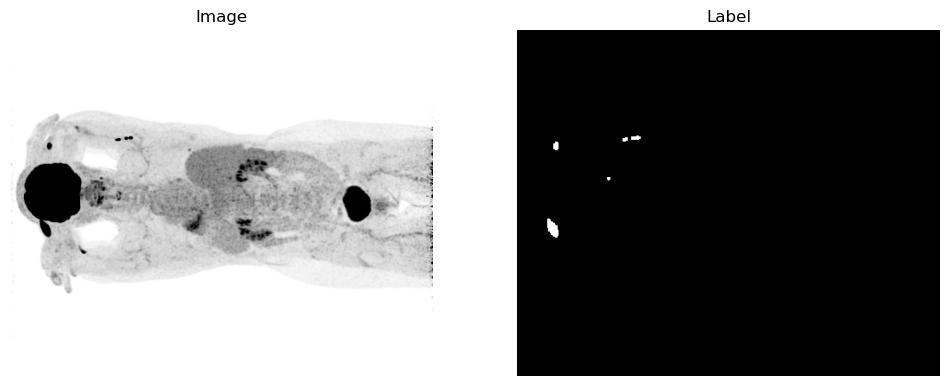

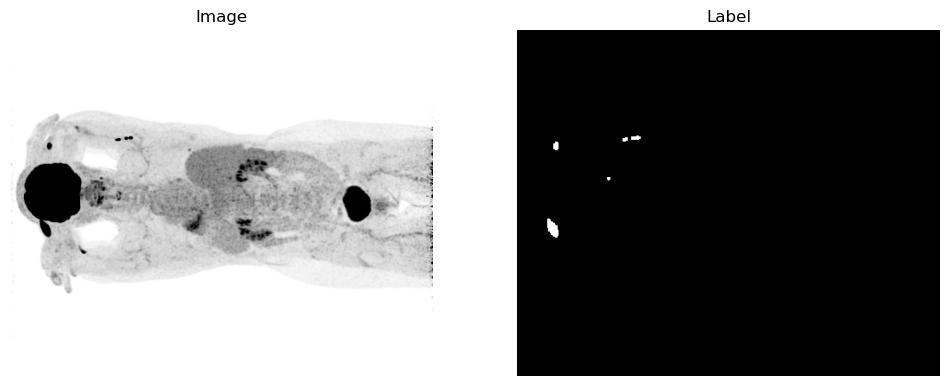

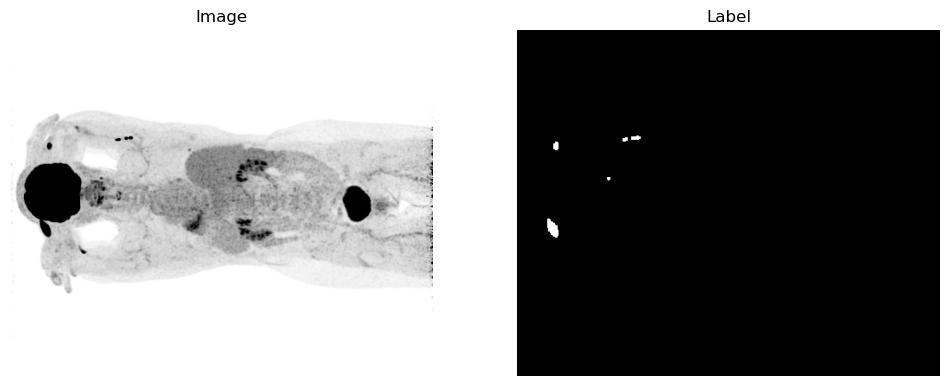

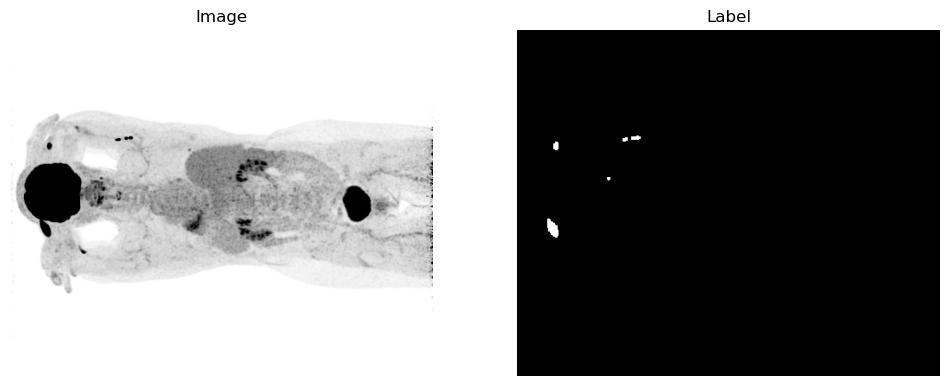

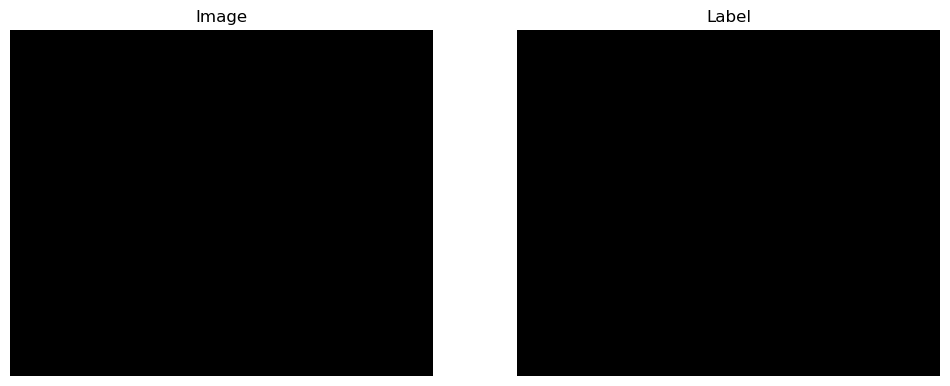

AssertionError: 

In [9]:
one_subject = dataset[0]

print('Subject:', one_subject)
print('Image:', one_subject.img)
print('Label:', one_subject.label)

# Extracting the image and label arrays
image_array = one_subject['img'][tio.DATA].squeeze().numpy()  # Assuming 'img' is the key for images
label_array = one_subject['label'][tio.DATA].squeeze().numpy()  # Assuming 'label' is the key for labels

# Choosing a slice to display, for example, the middle slice
slice_idx = image_array.shape[0] // 2
image_slice = image_array[slice_idx, :, :]
label_slice = label_array[slice_idx, :, :]

def plot_example(image_slice, label_slice):
    # Plotting the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title('Label')
    axes[1].axis('off')

    plt.show()

plot_example(image_slice, label_slice)
plot_example(image_array[0, :, :], label_array[0, :, :])
plot_example(image_array[1, :, :], label_array[1, :, :])
plot_example(image_array[2, :, :], label_array[2, :, :])
plot_example(image_array[3, :, :], label_array[3, :, :])


(4, 400, 489)


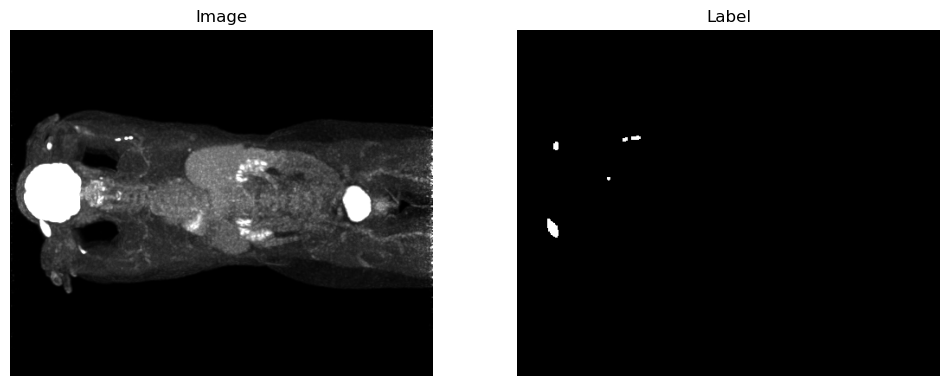

In [48]:
# Assuming the images are 8-bit, maximum value would be 255
max_value = 255 # 1 looks very interesting...

print(image_array.shape)

# Inverting the image array
inverted_image_array = max_value - image_array

# Convert the numpy array back to a Tensor with the correct shape
inverted_image_tensor = torch.from_numpy(inverted_image_array).to(torch.uint8)  # Ensure the data type is correct

# Updating the one_subject object with the inverted image and original label
one_subject['img'][tio.DATA] = inverted_image_tensor.unsqueeze(-1)
one_subject['label'][tio.DATA] = torch.from_numpy(label_array).unsqueeze(-1)  # Ensure label array is correctly formatted

image_array = one_subject.img[tio.DATA].squeeze().numpy()
label_array = one_subject.label[tio.DATA].squeeze().numpy()

slice_idx = image_array.shape[0] // 2
image_slice = image_array[slice_idx, :, :]
label_slice = label_array[slice_idx, :, :]

plot_example(image_slice, label_slice)

## Preprocessing the images

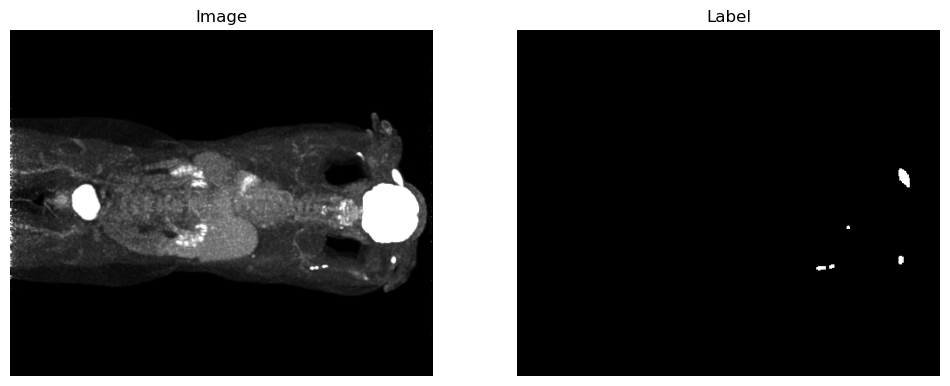

In [49]:
# to canonical

to_canonical = tio.ToCanonical()
subject_canonical = to_canonical(one_subject)

plot_example(subject_canonical['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_canonical['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])


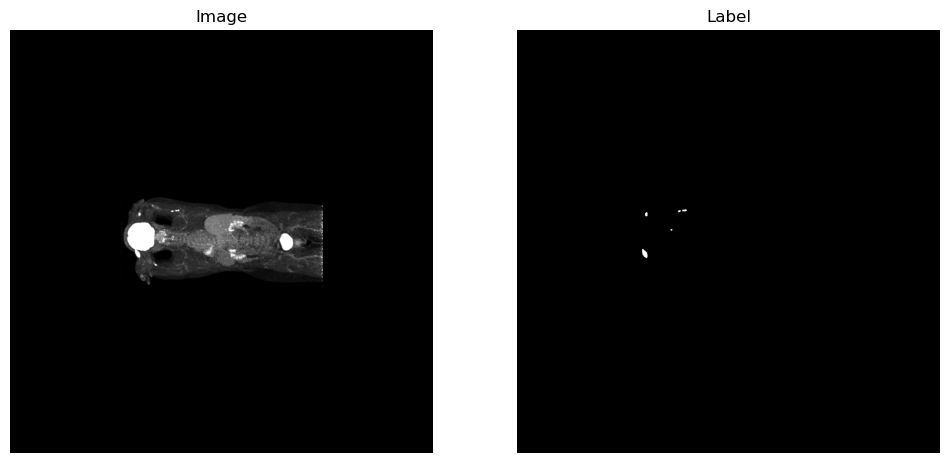

In [50]:
# crop or pad

target_shape = 1024, 1024, 1 # good size for U-Net
cropper = tio.CropOrPad(target_shape)
subject_cropped = cropper(one_subject)

plot_example(subject_cropped['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_cropped['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

## Augmentation

/home/asp/anaconda3/lib/python3.11/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Input image is 2D, but "2" is in axes: (0, 1, 2)
  transformed = self.apply_transform(subject)


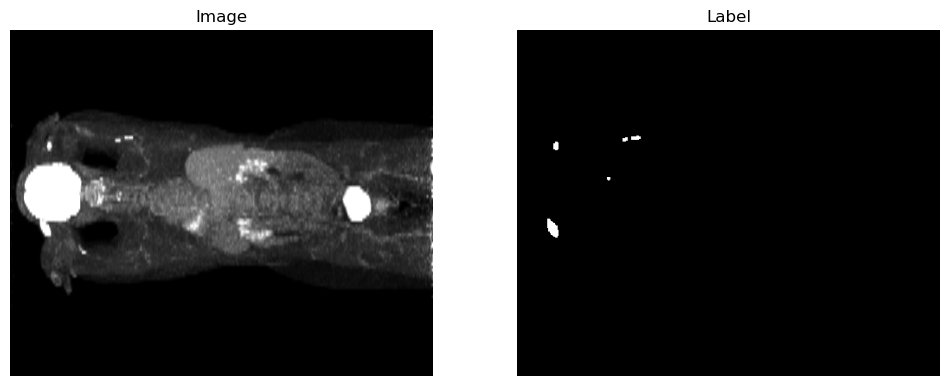

In [51]:
# random anisotropy

anisotropy = tio.RandomAnisotropy()
subject_anisotropy = anisotropy(one_subject)

plot_example(subject_anisotropy['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_anisotropy['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

KeyboardInterrupt: 

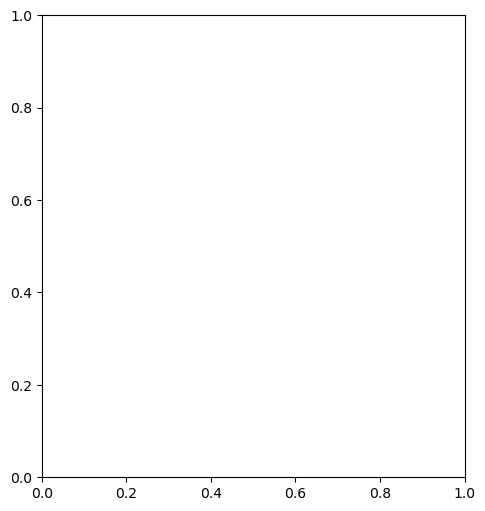

In [52]:
# random affine

random_affine = tio.RandomAffine()
subject_affine = random_affine(one_subject)

plot_example(subject_affine['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_affine['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

random_affine_zoom = tio.RandomAffine(scales=(1.5, 1.5))
subject_affine_zoom = random_affine_zoom(one_subject)

plot_example(subject_affine_zoom['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_affine_zoom['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

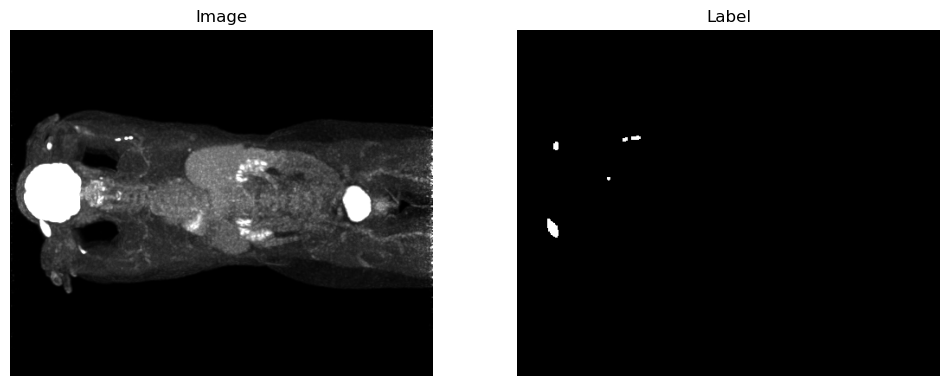

In [ ]:
# random flip

random_flip = tio.RandomFlip(axes=['inferior-superior'], flip_probability=1)
subject_flip = random_flip(one_subject)

plot_example(subject_flip['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_flip['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

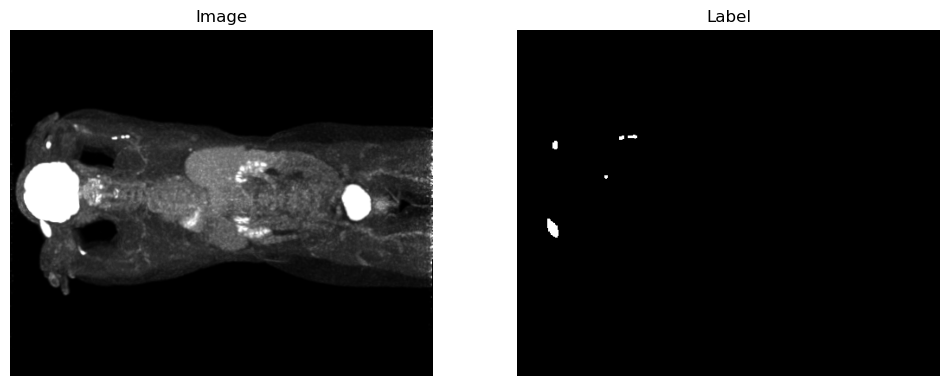

In [ ]:
# random elastic deformation

max_displacement = 10, 10, 0
max_control_points = 10

random_elastic = tio.RandomElasticDeformation(max_displacement=max_displacement, num_control_points=max_control_points)
subject_elastic = random_elastic(one_subject)

plot_example(subject_elastic['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_elastic['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

## Intensity Transforamtions

In [ ]:
# check if there are nans or infs in the data or values outside of the range

def check_nans_and_range(subject):
    image = subject['img'][tio.DATA]
    label = subject['label'][tio.DATA]
    print('Image has NaNs:', torch.isnan(image).any())
    print('Image has Infs:', torch.isinf(image).any())
    print('Image min:', image.min())
    print('Image max:', image.max())
    print('Label has NaNs:', torch.isnan(label).any())
    print('Label has Infs:', torch.isinf(label).any())
    print('Label min:', label.min())
    print('Label max:', label.max())

check_nans_and_range(one_subject)




Image has NaNs: tensor(False)
Image has Infs: tensor(False)
Image min: tensor(0, dtype=torch.uint8)
Image max: tensor(255, dtype=torch.uint8)
Label has NaNs: tensor(False)
Label has Infs: tensor(False)
Label min: tensor(0, dtype=torch.uint8)
Label max: tensor(255, dtype=torch.uint8)


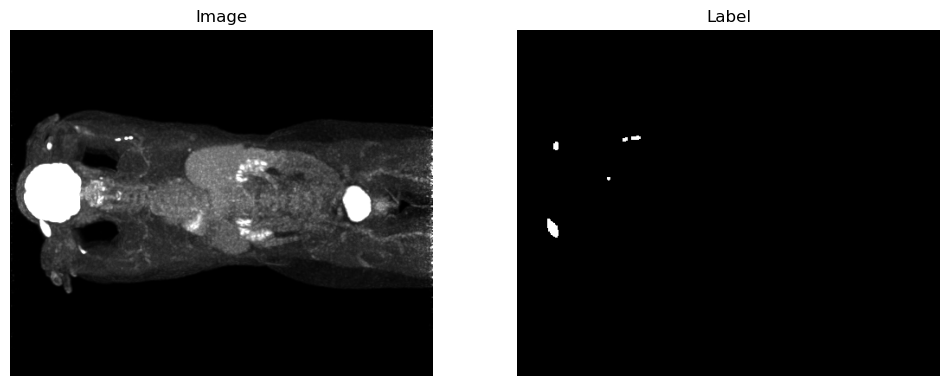

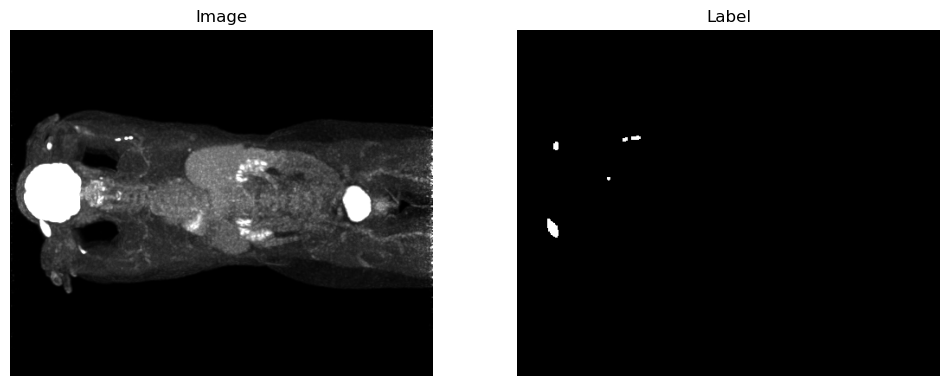

/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

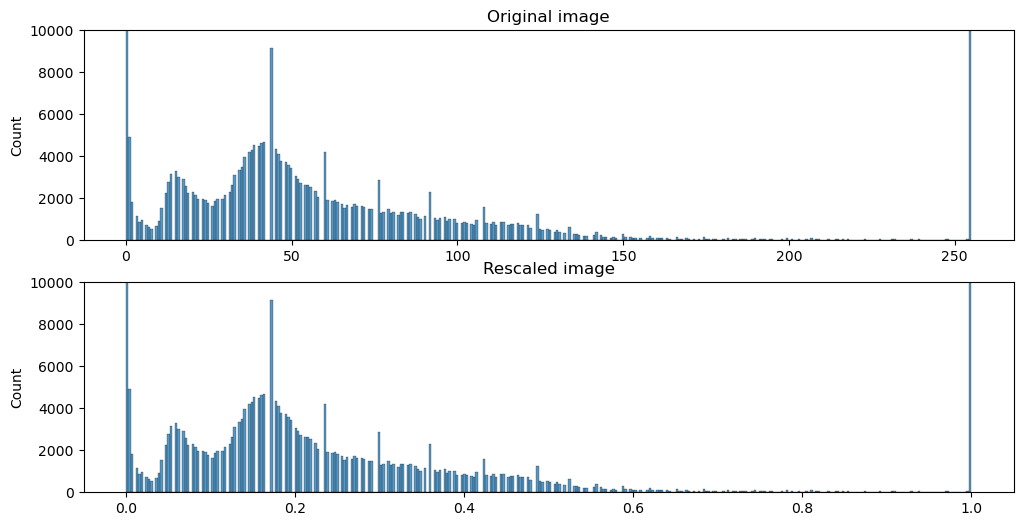

In [ ]:
# rescale intensity



rescale_intensity = tio.RescaleIntensity((0, 1), percentiles=(1, 99))
subject_rescale = rescale_intensity(one_subject)
#plot original and rescaled image
plot_example(one_subject['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                one_subject['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
plot_example(subject_rescale['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_rescale['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

# histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(one_subject['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[0])
sns.histplot(subject_rescale['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[1])
axes[0].set_title('Original image')
axes[0].set_ylim(0, 10000)
axes[1].set_title('Rescaled image')
axes[1].set_ylim(0, 10000)
plt.show()

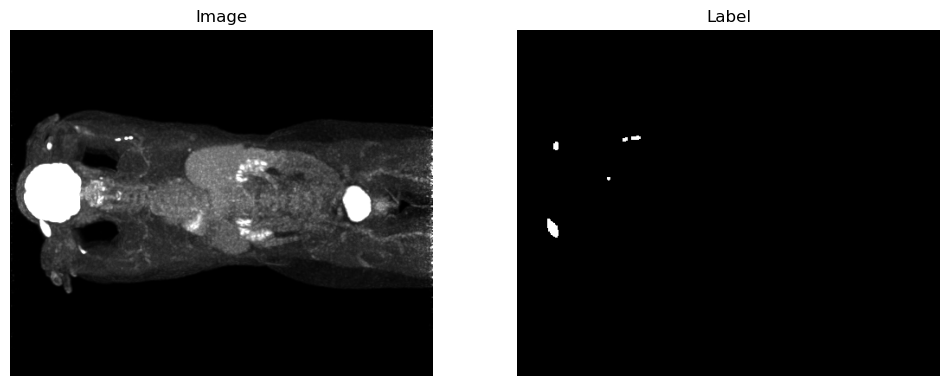

/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

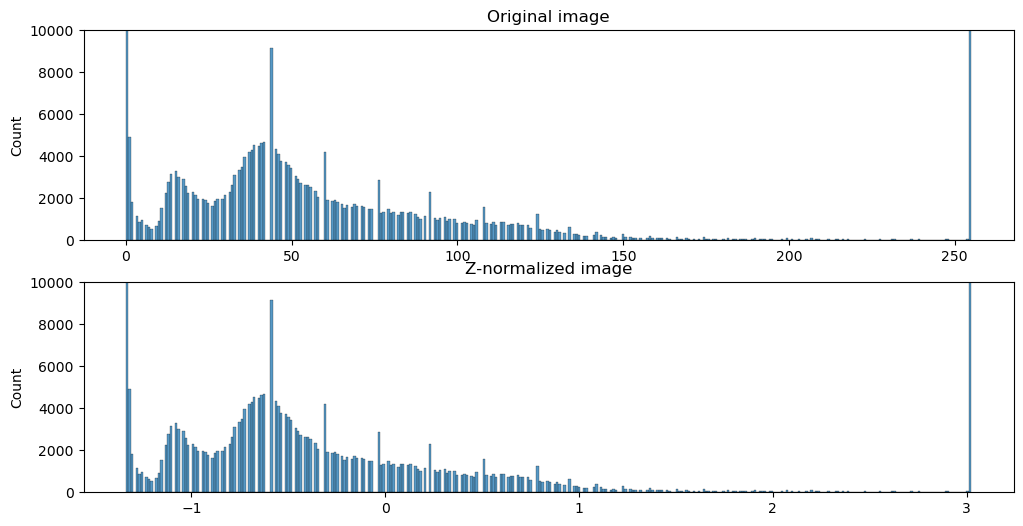

In [ ]:
# z normalization

z_normalization = tio.ZNormalization(masking_method=tio.ZNormalization.mean)
subject_znorm = z_normalization(one_subject)

plot_example(subject_znorm['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_znorm['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

# histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(one_subject['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[0])
sns.histplot(subject_znorm['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[1])
axes[0].set_title('Original image')
axes[0].set_ylim(0, 10000)
axes[1].set_title('Z-normalized image')
axes[1].set_ylim(0, 10000)
plt.show()


# TODO: It might be possible to rescale the histogram. This way some properties might be better visible than others

## Augmentation

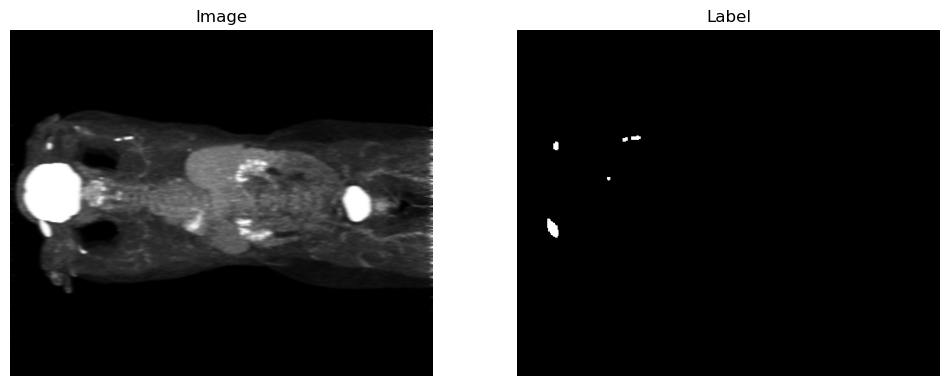

In [ ]:
# blur

blur = tio.RandomBlur()
subject_blur = blur(subject_znorm)

plot_example(subject_blur['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_blur['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
                

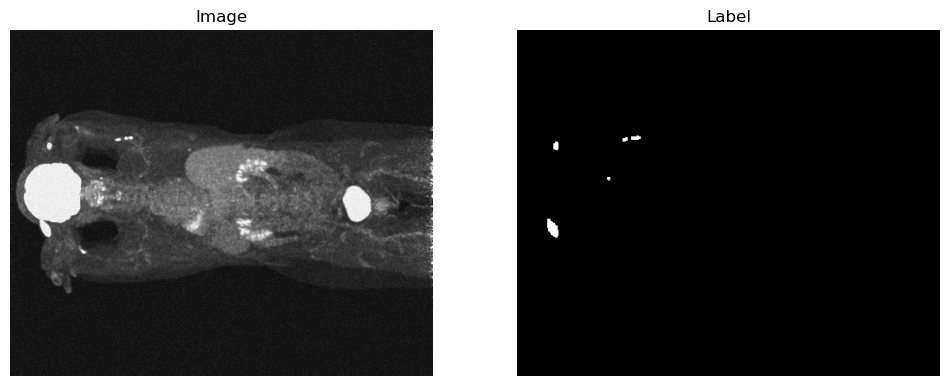

In [ ]:
# random noise

noise = tio.RandomNoise(std=(0.1)) # do znormalization first!!!
subject_noise = noise(subject_znorm)

plot_example(subject_noise['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_noise['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])



## Medical images specific transformations

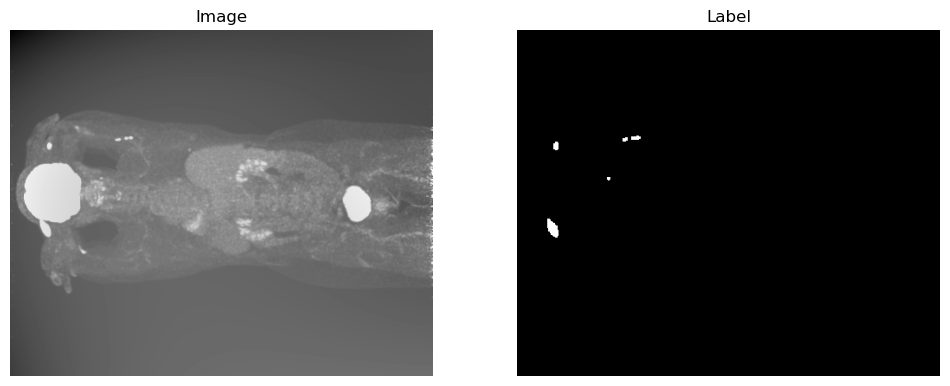

In [ ]:
#random bias

bias = tio.RandomBiasField(coefficients=.5)
subject_bias = bias(subject_znorm)

plot_example(subject_bias['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_bias['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])


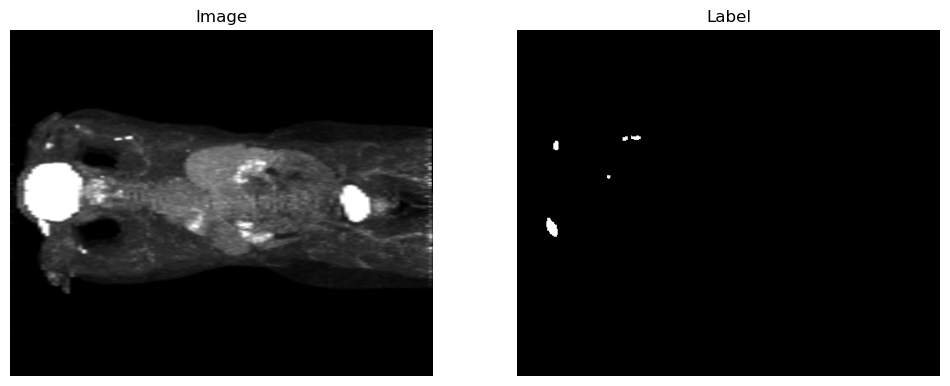

In [ ]:
#several transforms

transform = tio.Compose([
    anisotropy,
    random_elastic,
])
subject_transform = transform(one_subject)

plot_example(subject_transform['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_transform['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
    

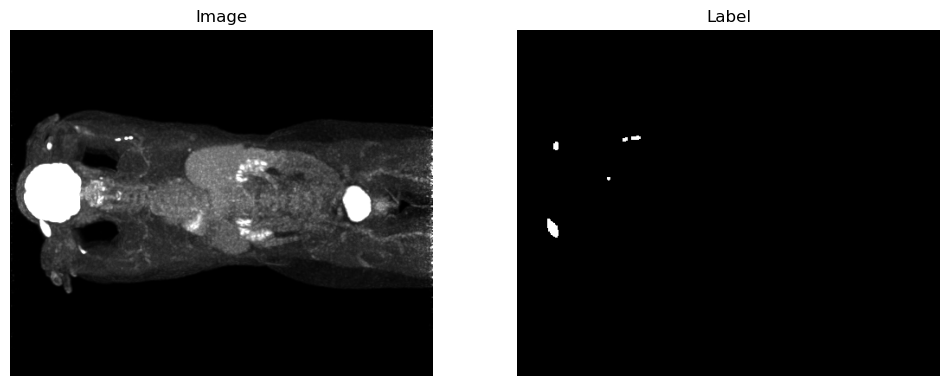

In [ ]:
# one of

spatial_transform = tio.OneOf({
    random_affine,
    random_elastic,
    random_flip,
})
subject_spatial = spatial_transform(one_subject)

plot_example(subject_spatial['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_spatial['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])



In [ ]:
class MIPDataset(Dataset):
    def __init__(self, path_to_img, path_to_mask, path_to_controls=None, include_controls=True, transform=None):
        self.path_to_img = path_to_img
        self.path_to_mask = path_to_mask
        self.include_controls = include_controls
        self.transform = transform

        self.imgs = [os.path.join(path_to_img, img) for img in os.listdir(path_to_img)]
        self.masks = [os.path.join(path_to_mask, mask) for mask in os.listdir(path_to_mask)]
        
        # Only include controls if specified
        if path_to_controls and self.include_controls:
            controls = [os.path.join(path_to_controls, img) for img in os.listdir(path_to_controls)]
            self.imgs.extend(controls)
            # Extend the mask list with empty masks for controls
            self.masks.extend([None] * len(controls))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)
        img = img.convert('L')  # Convert to grayscale

        mask = None
        if self.masks[idx]:  # If it is a tumor image or a control image with an empty mask
            mask_path = self.masks[idx]
            if mask_path:
                mask = Image.open(mask_path)
                mask = mask.convert('L')  # Convert to grayscale
            else:
                mask = Image.new('L', img.size)  # Create an empty (black) mask

        max_width, max_height = 400, 991

        # Pad the image and mask to the max_width and max_height
        img = TF.pad(img, self.calculate_padding(img.size, max_width, max_height), fill=255, padding_mode='constant')
        mask = TF.pad(mask, self.calculate_padding(mask.size, max_width, max_height), fill=0, padding_mode='constant')

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask
    
    def calculate_padding(self, current_size, max_width, max_height):
        left = (max_width - current_size[0]) // 2
        top = (max_height - current_size[1]) // 2
        right = max_width - current_size[0] - left
        bottom = max_height - current_size[1] - top
        return (left, top, right, bottom)
    
    def load_subset(self, num_samples):
        # Shuffle the list of images and select a subset
        combined_list = list(zip(self.imgs, self.masks))
        random.shuffle(combined_list)
        self.imgs, self.masks = zip(*combined_list[:num_samples])


## Analyse Pre-processing

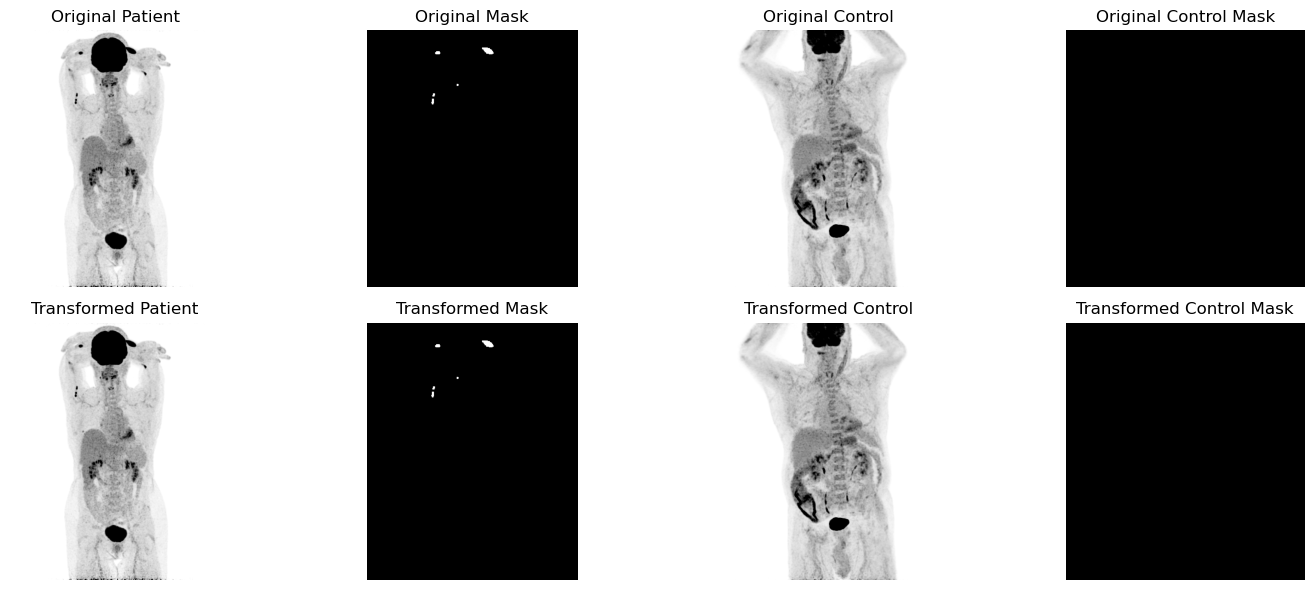

In [ ]:
# Load the images
patient_img_path = 'data/patients/imgs/patient_000.png'
patient_mask_path = 'data/patients/labels/segmentation_000.png'
control_img_path = 'data/controls/imgs/control_000.png'

patient_img = Image.open(patient_img_path).convert('L')
patient_mask = Image.open(patient_mask_path).convert('L')
control_img = Image.open(control_img_path).convert('L')
control_mask = Image.new('L', control_img.size)  # Create an empty (black) mask for control

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply transformations
transformed_patient_img = transform(patient_img)
transformed_patient_mask = transform(patient_mask)
transformed_control_img = transform(control_img)
transformed_control_mask = transform(control_mask)

# Function to display images
def display_images_side_by_side(images, titles):
    # Set up the matplotlib figure and axes, based on the number of images
    fig, axs = plt.subplots(2, 4, figsize=(15, 6))
    axs = axs.ravel()

    for i, (img, title) in enumerate(zip(images, titles)):
        # If the image is a tensor, we need to process it differently from a PIL image
        if isinstance(img, torch.Tensor):
            # Convert tensor to numpy array
            img = img.numpy().squeeze()
            # Undo the normalization to display the image correctly
            img = (img * 0.5) + 0.5
        else:
            # For PIL images, we just convert to numpy array
            img = np.array(img)

        # Display image
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(title)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Original images as PIL images and numpy arrays for non-transformed control mask
original_images = [patient_img, patient_mask, control_img, np.array(control_mask)]

# Transformed images as PyTorch tensors
transformed_images = [transformed_patient_img, transformed_patient_mask, transformed_control_img, transformed_control_mask]

# Titles for the images
image_titles = ['Original Patient', 'Original Mask', 'Original Control', 'Original Control Mask',
                'Transformed Patient', 'Transformed Mask', 'Transformed Control', 'Transformed Control Mask']

# Combine the original and transformed images and their titles into lists
all_images = original_images + transformed_images
all_titles = image_titles

# Display the images
display_images_side_by_side(all_images, all_titles)

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 1
learning_rate = 1e-6

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create dataset, with include_controls set to False to exclude healthy patients
dataset = MIPDataset(path_to_img='data/patients/imgs/',
                     path_to_mask='data/patients/labels/',
                     path_to_controls='data/controls/imgs/',
                     include_controls=False,  # Set to False to exclude controls
                     transform=transform)

dataset.load_subset(num_samples=50)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Device configuration - uses GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = UNet(n_channels=1, n_classes=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Splitting dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Training the model
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    train_dice_scores = []
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        train_losses.append(loss.item())

        # Calculate Dice score for each batch
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        dice_score_batch = dice_score(masks.cpu().numpy(), preds.cpu().numpy())
        train_dice_scores.append(dice_score_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss and Dice score over the training epoch
    avg_train_loss = np.mean(train_losses)
    avg_train_dice_score = np.mean(train_dice_scores)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Dice Score: {avg_train_dice_score:.4f}')

    # Validation of the model
    model.eval()
    val_losses = []
    val_dice_scores = []
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        val_loss = criterion(outputs, masks)
        val_losses.append(val_loss.item())

        # Calculate Dice score for each batch
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        val_dice_score_batch = dice_score(masks.cpu().numpy(), preds.cpu().numpy())
        val_dice_scores.append(val_dice_score_batch)

        # Plot the prediction for the first batch in the validation set
        if i == 0:  # First batch
            plot_img = images[0].cpu().numpy().squeeze()
            plot_mask = masks[0].cpu().numpy().squeeze()
            plot_pred = preds[0].cpu().numpy().squeeze()

            # Convert from 1 channel to 3 channels for OpenCV compatibility
            plot_img = cv2.cvtColor(plot_img, cv2.COLOR_GRAY2BGR)
            plot_mask = cv2.cvtColor(plot_mask, cv2.COLOR_GRAY2BGR)
            plot_pred = cv2.cvtColor(plot_pred, cv2.COLOR_GRAY2BGR)

            plot_prediction(plot_img, plot_mask, plot_pred)

    # Calculate average loss and Dice score over the validation epoch
    avg_val_loss = np.mean(val_losses)
    avg_val_dice_score = np.mean(val_dice_scores)
    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Dice Score: {avg_val_dice_score:.4f}')

# Save the model checkpoint
torch.save(model.state_dict(), 'unet_model.pth')
print('Model trained and saved as unet_model.pth')


  0%|          | 0/10 [00:20<?, ?it/s]


KeyboardInterrupt: 